In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.colors as mcolors

import config
config.config(channel='shap',n_steps=20,cfg_bits=[0,1,0,1,0,1,1])

('TCPIP0::169.254.1.214::inst0::INSTR', 'GPIB1::9::INSTR', 'GPIB1::23::INSTR')
Agilent Technologies,B2961A,MY52350174,1.0.1236.9609


    Low terminal: FLO
    Auto output off: 1
    Protection: 1
    Resistance mode: FIX
    Shunt resistance : +2.00000000E+009
    Output current mode: FIX
    Output current level: -2.00000000E-006
    Output voltage range: +2.00000000E+000
    Output status: 1
        
HEWLETT-PACKARD,HP81104A,DE38700607,REV 01.10.00


    Number of pattern positions: +1000
    Source of the trigger: IMM
    Period of the pulse: +1.5000E-08
    Duty cycle of the pulse: +5.0000E+01
    Rise time of the pulse: +3.0000E-09
    Type of pulse: PATTERN
    CH1 data: 20 1's, 980 0's
    CH2 data: as the clock
    STRB data: 20 1's, 980 0's
    Type of the pulse: NRZ
    Internal impedance (source): +5.0000E+01
    External impedance (termination): +1.0000E+02
    High level: +1.2000E+00
    Low level: +0.0000E+00
    Output 1 status: 1
    Output 2 status: 1
        
LECROY,

In [12]:
print(config.lecroy.query('C2:CRVA? HREL').split(',')[2])

15.81E-3


In [2]:
channel_name = config.channel_name
gain = config.lemo_gain
N_samples = config.N_samples

df = pd.DataFrame()
df['Current level step'] = np.arange(len(config.current_lev))
df['Current level (A)'] = config.current_lev
df['Equivalent photons'] = config.eq_ph
df['Voltage output average (V)'] = None
df['Voltage output std (V)'] = None

# set cursor positions
# in future one must set vdiv, hdiv, ... TODO
# current: tdiv = 200 ns/div,, delay = -908 ns
ndiv = 10 # positive and negative around delay
tdelay = -908 # ns
tdiv = 200 # ns/div
osc_ts = 322 # ns
osc_te = osc_ts + config.peaking_time # TODO not ideal
osc_offset = - ndiv/2*tdiv - tdelay
div_s = (osc_ts - osc_offset)/tdiv
if config.channel_name == 'shap':
	div_e = (osc_te - osc_offset)/tdiv
else:
	div_e = (432 - osc_offset)/tdiv
config.lecroy.write(f'C1:CRST HDIF,{div_s},HREF,{div_e}')

for i, cl in enumerate(config.current_lev):
	# set current level
	config.ps.write(f':SOUR:CURR:LEV {cl}')
	time.sleep(0.005)
	data = []
	# N sample to average and extract std from
	for _ in range(N_samples):
		data.append(float(config.lecroy.query(f'C{config.channel_num}:CRVA? HREL').split(',')[2]))
		time.sleep(0.03)
	
	df.loc[i,'Voltage output average (V)'] = np.average(data)/gain
	df.loc[i,'Voltage output std (V)'] = np.std(data)/gain

datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
if channel_name == 'csa':
	df['Voltage output average (V)'] = -1*df['Voltage output average (V)']

df.to_csv(f'G:/My Drive/PHD/FALCON/measures/transcharacteristics/{channel_name}/{channel_name}_{config.config_bits_str}_nominal_{datetime_str}.tsv', sep='\t')

In [ ]:
path = 'G:/My Drive/PHD/FALCON/measures/transcharacteristics/csa/csa_0101011_nominal_150424_145256.tsv'
df = pd.read_csv(path,sep='\t')
datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
arr_split = path.split('/')
channel_name = arr_split[6]
config_bits_str = arr_split[-1].split('_')[1]
config_bits = [int(x) for x in config_bits_str]
config.config(channel=channel_name,n_steps=20,cfg_bits=config_bits)

LinregressResult(slope=0.002416269676578444, intercept=0.0002360980408163127, rvalue=0.9985094343132185, pvalue=3.430630163872021e-24, stderr=3.11304672765755e-05, intercept_stderr=0.0046612831261562794)


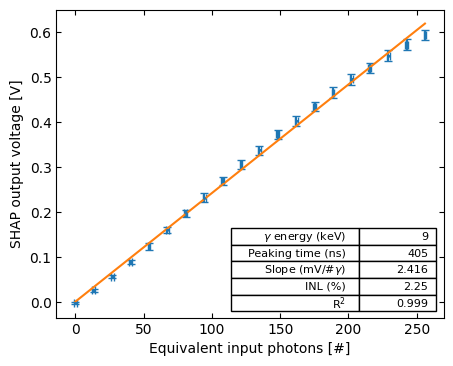

In [3]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(5)
photon_span = np.linspace(0,256,20)
ax.errorbar(
	photon_span,
	df['Voltage output average (V)'],
	xerr=np.tile(1, df.shape[0]),
	yerr=df['Voltage output std (V)'],
	fmt='s', markersize=1, capsize=3)
ax.set_xlabel('Equivalent input photons [#]')
ax.set_ylabel(f'{channel_name.upper()} output voltage [V]')
ax.tick_params(right=True, top=True, direction='in')

from scipy import stats
ln = stats.linregress(
	#df[df['Equivalent photons'].between(eq_ph[0],eq_ph[-1])]['Equivalent photons'].astype(float),
	photon_span,
	df['Voltage output average (V)'].astype(float))
linear_output = ln.intercept + ln.slope*np.linspace(0,256,20)
ax.plot(
	photon_span,
    linear_output
)
max_diff = np.max(df['Voltage output average (V)'] - linear_output)
inl = 100 * np.abs(max_diff) / ln.slope / 256
print(ln)
ax.table([
	['$\\gamma$ energy (keV)',f'{config.photon_energy}'],
	['Peaking time (ns)',f'{config.peaking_time}'],
	['Slope (mV/#$\\gamma$)',f'{np.round(ln.slope*10**3,3)}'],
	['INL (%)',f'{np.round(inl,2)}'],
	['R$^2$',np.round(ln.rvalue,3)],
	], colWidths=[.33,.2], loc='lower right')
plt.savefig(f'G:/My Drive/PHD/FALCON/measures/transcharacteristics/{channel_name}/{channel_name}_{config.config_bits_str}_nominal_{datetime_str}.pdf',dpi=300)